### PURPOSE
This notebook is used to merge the wikidata dataset with the original dataset

In [10]:
import pandas as pd
import numpy as np
import json
import requests
import matplotlib.pyplot as plt
import ast

In [3]:


# Load dataset
PATH = './data'

# Read the data
df = pd.read_csv(f"{PATH}/movie.metadata.tsv", names=[
    "Wikipedia movie ID",
    "Freebase movie ID",
    "Movie name",
    "Movie release date",
    "Movie box office revenue",
    "Movie runtime",
    "Movie languages",
    "Movie countries",
    "Movie genres"
], header=None, sep="\t")

# keep first 5 rows
# df = df.iloc[:5]

# Adjust the 'extract_values' function to handle both languages and countries
def extract_values(d):
    return ast.literal_eval(d).values()

def extract_first(x):
    if pd.isna(x):
        return x  # Return NaN as is
    values_list = list(x)
    return values_list[0] if len(values_list) > 0 else []

df['Movie countries'] = df['Movie countries'].apply(extract_values).apply(extract_first)
df['Movie languages'] = df['Movie languages'].apply(extract_values).apply(extract_first)
df['Movie genres'] = df['Movie genres'].apply(extract_values).apply(lambda x: list(x))


print(df.head())


   Wikipedia movie ID Freebase movie ID  \
0              975900         /m/03vyhn   
1             3196793         /m/08yl5d   
2            28463795        /m/0crgdbh   
3             9363483        /m/0285_cd   
4              261236         /m/01mrr1   

                                          Movie name Movie release date  \
0                                     Ghosts of Mars         2001-08-24   
1  Getting Away with Murder: The JonBenét Ramsey ...         2000-02-16   
2                                        Brun bitter               1988   
3                                   White Of The Eye               1987   
4                                  A Woman in Flames               1983   

   Movie box office revenue  Movie runtime     Movie languages  \
0                14010832.0           98.0    English Language   
1                       NaN           95.0    English Language   
2                       NaN           83.0  Norwegian Language   
3                       Na

In [21]:
# Read the data into a DataFrame
df = pd.read_csv(f"{PATH}/film_wiki_data.csv")

# Group by 'filmLabel' and keep the row with the max 'boxOffice' for each group
# Each film has different lines some is box office worldwide or per country
df_max_box_office = df.loc[df.groupby('filmLabel')['boxOffice'].idxmax()]
df_max_box_office = df_max_box_office.reset_index(drop=True)

print(df_max_box_office.head())



# Load conversion rates from JSON file
with open(f"{PATH}/usd_conversion_rates.json", 'r') as file:
    conversion_rates = json.load(file)

# Function to convert currency using ExchangeRate API
def convert_to_usd(amount, currency):
    rate = conversion_rates.get(currency, 1)  # Default to 1 if currency not found
    return float(amount) / float(rate)


def get_wikipedia_page_id(film_name):
    # Replace spaces with underscores for the Wikipedia API format
    film_name_formatted = film_name.replace(' ', '_')
    print(film_name_formatted)

    url = f"https://en.wikipedia.org/w/api.php"

    params = {
        'action': 'query',
        'format': 'json',
        'titles': film_name_formatted
    }

    response = requests.get(url, params=params)

    if response.status_code == 200:
        try:
            data = response.json()
            page_id = next(iter(data['query']['pages']))
            return page_id
        except KeyError:
            print(f"No page found for {film_name}")
            return None
    else:
        print("Failed to fetch data from Wikipedia")
        return None

# Function to apply conversion to each row
def convert_row(row):
    if row['currencyCode'] != 'USD':
        row['cost'] = convert_to_usd(row['cost'], row['currencyCode'])
        row['boxOffice'] = convert_to_usd(row['boxOffice'], row['currencyCode'],)
        row['currencyCode'] = 'USD'

        # Fetch and add the Wikipedia page ID
    row['wikiPageID'] = get_wikipedia_page_id(row['filmLabel'])

    return row

# Apply the conversion to each row
df_max_box_office = df_max_box_office.apply(convert_row, axis=1)

print(df_max_box_office.head())

                    filmLabel        cost    boxOffice currencyCode
0       "Crocodile" Dundee II   9000000.0  239606210.0          USD
1        (500) Days of Summer   7500000.0   60700000.0          USD
2      ...And Justice for All   4000000.0   33300000.0          USD
3         10 Cloverfield Lane  15000000.0   71897215.0          ARS
4  10 Things I Hate About You  13000000.0   53478579.0          USD
No page found for It: Chapter Two
                    filmLabel          cost     boxOffice currencyCode  \
0       "Crocodile" Dundee II  9.000000e+06  2.396062e+08          USD   
1        (500) Days of Summer  7.500000e+06  6.070000e+07          USD   
2      ...And Justice for All  4.000000e+06  3.330000e+07          USD   
3         10 Cloverfield Lane  4.285347e+04  2.054030e+05          USD   
4  10 Things I Hate About You  1.300000e+07  5.347858e+07          USD   

  wikiPageID  
0   23002767  
1   41468978  
2   24712812  
3   44662181  
4     398934  


In [25]:
# remove if page id is not defined
df_max_box_office = df_max_box_office[df_max_box_office['wikiPageID'] != -1]
# save csv without row index
df_max_box_office.to_csv(f'{PATH}/wiki_data_formatted.csv', index=False)


In [27]:
# Load the first CSV file
df1 = pd.read_csv(f'{PATH}/wiki_data_formatted.csv')

# Load the second CSV file
df2 = pd.read_csv(f"{PATH}/movie.metadata.tsv", names=[
    "wikiPageID",
    "freebaseMovieID",
    "movieName",
    "movieReleaseDate",
    "movieBoxOfficeRevenue",
    "movieRuntime",
    "movieLanguages",
    "movieCountries",
    "movieGenres"
], header=None, sep="\t")

# Merge the DataFrames on the 'id' column
merged_df = pd.merge(df1, df2, on='wikiPageID', how='inner')

# Save the merged DataFrame to a new CSV file
merged_df.to_csv('merged_file.csv', index=False)



In [31]:

# show me the lowest cost 100 films from merged df
df = merged_df.sort_values(by=['cost'], ascending=True) 
df = df.iloc[:100]
print(df)

                     filmLabel          cost     boxOffice currencyCode  \
161                       Darr  2.715000e+02  3.480000e+06          USD   
327            Keechaka Vadham  4.203129e+02  6.004470e+02          USD   
443            Pather Panchali  1.801341e+03  2.521877e+05          USD   
252       Gentlemen of Fortune  4.344898e+03  3.258674e+05          USD   
229                  Following  6.000000e+03  4.850000e+04          USD   
..                         ...           ...           ...          ...   
472                Rear Window  1.000000e+06  3.703451e+07          USD   
588           The Big Hangover  1.026000e+06  1.626000e+06          USD   
629                    The Fog  1.100000e+06  2.144878e+07          USD   
476  Requiem for a Heavyweight  1.100000e+06  1.300000e+06          USD   
114           Bringing Up Baby  1.100000e+06  1.259000e+06          USD   

     wikiPageID freebaseMovieID                  movieName movieReleaseDate  \
161   2105280.0     

0    13000000.0
1     4520000.0
2    29500000.0
3    18000000.0
4    76000000.0
Name: cost, dtype: float64


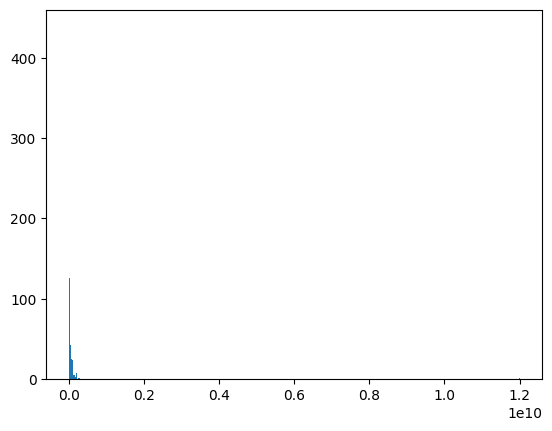

In [42]:
# do a graph of the ditributon of the cost of the films histogram
print(merged_df['cost'].head())
plt.hist(merged_df['cost'], bins=800)
# do log x scale
plt.xscale('log')
plt.show()
